In [4]:
import os 
os.chdir("../..")

In [7]:
import numpy as np
import json
from detectron2.structures import BoxMode
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt


from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from src.utils.dataset import split_train_val_test, get_detectron2_dataset_dicts, register_detectron2_datasets
import pickle

In [3]:
if os.path.exists("data/szprotawa_splits.pkl"):
    with open("./data/szprotawa/szprotawa_splits.pkl", "rb") as f:
        splits = pickle.load(f)
else:
    samples = pd.read_pickle("./data/szprotawa/szprotawa_patches_256/annotation.pkl")["patch_number"].unique()
    splits = split_train_val_test(samples, 0.7, 0.15, 0.15)
    with open("./data/szprotawa/szprotawa_splits.pkl", "wb") as f:
        pickle.dump(splits, f)


register_detectron2_datasets("szprotawa", "./data/szprotawa/szprotawa_patches_256/", 
                                      splits, min_bbox_area=200, 
                                      limits={"train": -1, "val": -1, "test": -1})

In [4]:
!ls data/szprotawa/

 RGB_szprotawa_transparent_mosaic_group1.tif   szprotawa_splits.pkl
 szprotawa_patches_256			       Szprotawa_translated_EVI.tif
'szprotawa shp'


In [7]:
meta = MetadataCatalog.get("szprotawa_train")
meta

Metadata(name='szprotawa_train', thing_classes=['SickTrees'])

In [8]:
# dataset_dicts = get_szprotawa_dicts("data/szprotawa_patches_256/")
dataset_dicts = DatasetCatalog.get("szprotawa_val")
len(dataset_dicts)

889

In [57]:
d = get_detectron2_dataset_dicts("./data/szprotawa/szprotawa_patches_256/",
                             splits['val'],
                             200,
                             100)
len(d)

89

In [58]:
d[0]

{'file_name': './data/szprotawa/szprotawa_patches_256/patch_6487.png',
 'image_id': 6487,
 'height': 256,
 'width': 256,
 'annotations': [{'bbox': [184, 126, 247, 168],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}

In [7]:
splits.keys()

dict_keys(['train', 'val', 'test'])

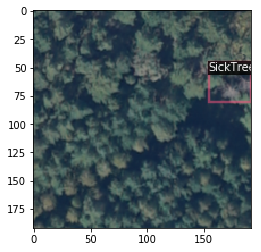

In [8]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir tboard_logs

Reusing TensorBoard on port 6006 (pid 23120), started 20:07:22 ago. (Use '!kill 23120' to kill it.)

In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [9]:
from datetime import datetime

In [9]:
# cfg = get_cfg()

# cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_test_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# cfg.DATASETS.TRAIN = ("szprotawa_train",)
# cfg.DATASETS.TEST = ("szprotawa_val",)
# cfg.DATALOADER.NUM_WORKERS = 4

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
# cfg.SOLVER.MAX_ITER = 30_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.SOLVER.CHECKPOINT_PERIOD = 250


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)

# cfg.TEST.EVAL_PERIOD = 500 #200
# cfg.TEST.DETECTIONS_PER_IMAGE = 10

# cfg.VIS_PERIOD = 100

Loading config /home/mkosturek/miniconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [19]:
cfg = get_cfg()

cfg.OUTPUT_DIR = "tboard_logs/retinanet_test_2020-01-21T23:40/"
# cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_test_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("szprotawa_train",)
cfg.DATASETS.TEST = ("szprotawa_val", )
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 30_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 250


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)

cfg.TEST.EVAL_PERIOD = 50 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 100

Loading config /home/mkosturek/miniconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [68]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


class Trainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR+f"/eval/{dataset_name}")


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[01/22 20:11:20 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[01/22 20:11:23 d2.engine.train_loop]: Starting training from iteration 0
[01/22 20:11:29 d2.utils.events]: eta: 2:39:46  iter: 19  total_loss: 1.582  loss_cls: 1.119  loss_box_reg: 0.449  time: 0.3222  data_time: 0.0161  lr: 0.000002  max_mem: 3143M
[01/22 20:11:36 d2.utils.events]: eta: 2:42:09  iter: 39  total_loss: 1.570  loss_cls: 1.125  loss_box_reg: 0.450  time: 0.3268  data_time: 0.0065  lr: 0.000004  max_mem: 3143M
[01/22 20:11:40 d2.evaluation.evaluator]: Start inference on 889 images
[01/22 20:11:40 d2.evaluation.evaluator]: Inference done 11/889. 0.0403 s / img. ETA=0:00:36
[01/22 20:11:45 d2.evaluation.evaluator]: Inference done 130/889. 0.0409 s / img. ETA=0:00:31
[01/22 20:11:50 d2.evaluation.evaluator]: Inference done 249/889. 0.0409 s / img. ETA=0:00:26
[01/22 20:11:55 d2.evaluation.evaluator]: Inference done 368/889. 0.0409 s / img. ETA=0:00:21
[01/22 20:12:00 d2.evaluation.evaluator]: Inference done 487/889. 0.0409 s / img. ETA=0:00:16
[01/22 20:12:06 d2.evaluation.e

In [13]:
cfg.OUTPUT_DIR

'tboard_logs/retinanet_test_2020-01-21T23:40/'

In [20]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("szprotawa_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 50, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [21]:
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [20]:
1+2

3

In [21]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("szprotawa_test")

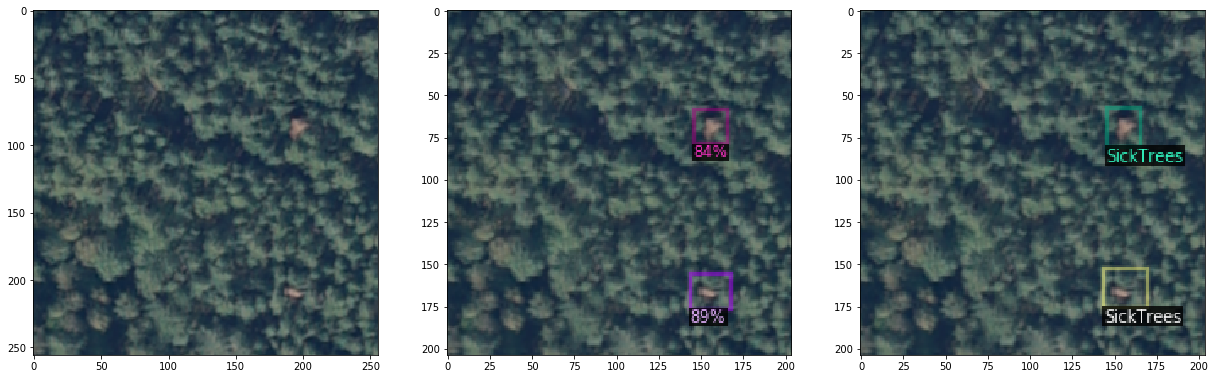

In [55]:
import time
for d in np.random.choice(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    f, a = plt.subplots(1,3, figsize=(21,7))
    a[0].imshow(im[:,:,::-1])
    a[1].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[2].imshow(vis.get_image())

In [54]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

TypeError: register_detectron2_datasets() takes from 3 to 5 positional arguments but 7 were given

In [34]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("szprotawa_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "szprotawa_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[01/21 00:14:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| SickTrees  | 1101         |
|            |              |
[01/21 00:14:54 d2.evaluation.evaluator]: Start inference on 895 images
[01/21 00:14:56 d2.evaluation.evaluator]: Inference done 11/895. 0.1688 s / img. ETA=0:02:30
[01/21 00:15:01 d2.evaluation.evaluator]: Inference done 40/895. 0.1707 s / img. ETA=0:02:27
[01/21 00:15:06 d2.evaluation.evaluator]: Inference done 69/895. 0.1716 s / img. ETA=0:02:23
[01/21 00:15:11 d2.evaluation.evaluator]: Inference done 98/895. 0.1717 s / img. ETA=0:02:18
[01/21 00:15:17 d2.evaluation.evaluator]: Inference done 127/895. 0.1715 s / img. ETA=0:02:12
[01/21 00:15:22 d2.evaluation.evaluator]: Inference done 156/895. 0.1715 s / img. ETA=0:02:07
[01/21 00:15:27 d2.evaluation.evaluator]: Inference done 185/895. 0.1714 s / img. ETA=0:02:02
[01/21 00:15:32 d2.evaluation.evaluator]: Inference done 212/895. 0.1730

OrderedDict([('bbox',
              {'AP': 17.52707701756293,
               'AP50': 51.79519398851464,
               'AP75': 6.7129691473728075,
               'APs': 14.56137909180918,
               'APm': 20.786019238948832,
               'APl': 16.021587682789452})])

In [ ]:
1+2

In [38]:
outputs.keys()

dict_keys(['instances'])